In [ ]:
!pip install feature-selector

In [ ]:
from datetime import datetime
import json5 as json
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

from multiprocessing import Pool, cpu_count

from feature_selector import FeatureSelector

In [2]:
# выгрузим в DTYPES названия полей и соответствующие им типы данных

with open('dtypes.json', 'r') as f:
    DTYPES = json.load(f)

## Preprocessing

In [ ]:
with open('dtypes.json', 'r') as f:
    DTYPES = json.load(f)
hydro_coord = pd.read_csv('track_2_package/hydro_coord.csv', dtype=DTYPES['hydro_coord'])

In [ ]:
lena=pd.read_csv('geo+evap.csv')

In [ ]:
geo_evap=lena.drop(columns=['Unnamed: 0','fid','lat','lon','name','distance_from_source','drainage_area','z_null'])

In [ ]:
geo=pd.get_dummies(geo_evap['GLG'])

In [ ]:
geo_evap=geo_evap.merge(geo, how='inner',left_index=True,right_index=True).drop(columns='GLG')

In [ ]:
hydro_coordge=hydro_coord.merge(geo_evap, how='inner',left_index=True,right_index=True)

In [ ]:
hydro_coordge.drop(columns='station_id_y', inplace=True)

In [ ]:
coord_map={i: 
 {hydro_coordge.iloc[:,2:].columns[j]
  :hydro_coordge.iloc[:,2:].iloc[index,j] for j in range(len(hydro_coordge.iloc[0,2:]))} 
   for index, i in enumerate(hydro_coordge['station_id_x'])}

In [ ]:
train=pd.read_csv('train_concat.csv')

In [ ]:
train.drop(columns=['stage_max','stage_avg','stage_min','temp','water_code','ice_thickness','snow_height','place','discharge'],inplace=True)

In [ ]:
test=pd.read_csv('cp4_test.csv')

In [ ]:
test['station_id'].unique()

In [ ]:
test.drop(columns=['delta_stage_max'],inplace=True)

In [ ]:
train=train.fillna(0)

In [ ]:
def id_station_to_numfeature(df,coord_map,id_column):
    dft=df.copy()
    for k in coord_map[3180].keys():
        dft[k]=0
    for i in coord_map.keys():
        for j in coord_map[i].keys():
            dft.loc[dft[id_column]==i,j] = coord_map[i][j]
    return dft

In [ ]:
train_4_net=id_station_to_numfeature(train,coord_map,'station_id')

In [ ]:
test_4_net=id_station_to_numfeature(test,coord_map,'station_id')

In [ ]:
test_4_net=test_4_net.reindex(columns=train_4_net.columns).drop(columns='delta_stage_max')

In [ ]:
test_4_net.to_csv('test_4_net.csv',index=False)

In [ ]:
train_4_net.to_csv('train_4_net.csv',index=False)

In [ ]:
train_4_net.sort_values('date')

In [ ]:
test_4_net.sort_values('date')

## interpolated_meteo

In [ ]:
meteo=pd.read_csv('interpolated_meteo_last.csv')
#meteo['date'] = pd.to_datetime(meteo['date'])

In [ ]:
h_station_dict={w:pd.DataFrame() for w in meteo['station_id'].unique()}
for i in meteo['station_id'].unique():
       h_station_dict[i]=meteo[meteo['station_id']==i]

In [ ]:
train=pd.read_csv('train_4_net.csv')
#train['date'] = pd.to_datetime(train['date'])

In [ ]:
meteo_dict_shift={}
for i in h_station_dict.keys():
    meteo_dict_shift[i]=h_station_dict[i].set_index('date').shift(7)

In [ ]:
meteo_shifted=pd.DataFrame()
for i in meteo_dict_shift.keys():
    meteo_shifted=meteo_shifted.append(meteo_dict_shift[i])
meteo_shifted.reset_index(inplace=True)

In [ ]:
ft=train.merge(meteo_shifted, how='left', left_on=['station_id','date'], right_on=['station_id','date'])


In [ ]:
ft=ft.fillna(0)

In [ ]:
ft.drop(columns=['station_id','date']).to_csv('full_train_met.csv',index=False)

In [ ]:
ft.drop(columns=['station_id','date'])

In [ ]:
test=pd.read_csv('test_4_net.csv')
test

In [ ]:
ftest=test.merge(meteo_shifted, how='left', left_on=['station_id','date'], right_on=['station_id','date'])

In [ ]:
ftest=ftest.fillna(0)
ftest.shape

In [ ]:
ftest.drop(columns=['station_id','date']).to_csv('full_test_met.csv',index=False)

In [ ]:
f_test=pd.read_csv('full_test_met.csv')

In [ ]:
f_test

## Feature_selection

In [3]:
#загружаем парсер

custom_date_parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d')

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

In [5]:
#загружаем interpolated_meteo из csv

interpolated_meteo = pd.read_csv('/Volumes/TOSHIBA/emergency/interpolated_meteo.csv',
                                 parse_dates=['date'], date_parser=custom_date_parser)

In [6]:
interpolated_meteo.shape

(336447, 71)

In [7]:
interpolated_meteo.columns

Index(['station_id', 'date', 'horizontal_visibility', 'cloud_amount_total',
       'cloud_base_altitude', 'wind_direction', 'wind_speed_aver',
       'soil_surface_temperature', 'air_temperature',
       'air_temperature_wet_bulb', 'water_vapour_partial_pressure',
       'relative_humidity', 'vapour_pressure_deficit', 'dew_point_temperature',
       'pressure', 'pressure_sea_level', 'barometric_tendency',
       'soil_surface_alco_temperature', 'soil_surface_temperature_min_before',
       'air_temperature_min_alco_temperature', 'air_temperature_min_before',
       'wind_speed_max', 'soil_surface_temperature_max_before',
       'soil_surface_max_temperature', 'air_temperature_max_before',
       'air_max_temperature', 'cloud_form_high_level',
       'cloud_form_middle_level', 'cloud_form_vertical_develop',
       'cloud_form_strat_stratocum', 'cloud_form_strat_rain',
       'cloud_below_station', 'soil_surface_condition', 'weather_before',
       'weather', 'air_temperature_wet_bulb_qu

In [8]:
null = pd.DataFrame(interpolated_meteo.isna().sum().sort_values(ascending=False))

In [9]:
#проверяем количество NaN в колонках

null

,0
soil_surface_condition,336447
ice_crust_aver,335367
ice_crust_route,335259
precipitation_corrected_mixed,326754
precipitation_corrected_liquid,326754
precipitation_corrected,326754
precipitation_observed,326754
precipitation_corrected_solid,326754
sunshine_hours,325485
snow_saturated_thickness,315549


In [10]:
interpolated_meteo.corr()

,station_id,horizontal_visibility,cloud_amount_total,cloud_base_altitude,wind_direction,wind_speed_aver,soil_surface_temperature,air_temperature,air_temperature_wet_bulb,water_vapour_partial_pressure,relative_humidity,vapour_pressure_deficit,dew_point_temperature,pressure,pressure_sea_level,barometric_tendency,soil_surface_alco_temperature,soil_surface_temperature_min_before,air_temperature_min_alco_temperature,air_temperature_min_before,wind_speed_max,soil_surface_temperature_max_before,soil_surface_max_temperature,air_temperature_max_before,air_max_temperature,cloud_form_high_level,cloud_form_middle_level,cloud_form_vertical_develop,cloud_form_strat_stratocum,cloud_form_strat_rain,cloud_below_station,soil_surface_condition,weather_before,weather,air_temperature_wet_bulb_qual_1,barometric_tendency_characteristic,precipitation,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,temperature_20cm,temperature_40cm,temperature_80cm,temperature_120cm,temperature_160cm,temperature_240cm,temperature_320cm,temperature_ks_5cm,temperature_ks_10cm,temperature_ks_15cm,temperature_ks_20cm,precipitation_observed,precipitation_corrected,precipitation_corrected_liquid,precipitation_corrected_mixed,precipitation_corrected_solid,sunshine_hours
station_id,1.000000,-0.078517,0.021415,0.082806,-0.059129,-0.034717,0.004942,0.006638,0.007062,0.010357,0.021171,-0.005551,0.010293,0.002469,0.019437,0.027897,0.009726,0.008426,0.010083,0.010808,-0.002352,0.005996,0.007892,0.009999,0.010455,0.002656,0.006385,0.065313,-0.018671,0.007558,0.000059,NaN,0.010955,0.019741,0.012788,-0.012693,0.022502,-0.002057,-0.002157,-0.000587,0.023483,0.020627,0.025636,0.015189,0.000374,0.003128,0.060812,-0.018530,-0.124808,0.006744,0.008686,0.026214,-0.041978,0.009108,0.012082,0.018848,0.004484,0.051997,0.024786,0.133911,-0.000721,0.000613,0.002024,0.004318,0.008505,0.008882,0.004201,-0.002094,0.001578,-0.024976
horizontal_visibility,-0.078517,1.000000,-0.203993,0.158527,0.067070,0.042886,0.081507,0.096166,-0.050653,-0.018192,-0.265099,0.093369,0.066259,0.004118,-0.031884,-0.039564,0.059922,0.058257,0.070714,0.067424,0.078663,0.109618,0.104934,0.113097,0.108052,-0.189519,-0.112638,-0.136517,-0.042068,-0.059793,0.001938,NaN,-0.280841,-0.278139,-0.002841,-0.030410,-0.154924,-0.136495,-0.052232,0.014075,-0.067172,-0.051280,-0.075241,0.109727,0.102230,-0.004631,0.007262,-0.011127,0.008620,0.067260,0.155172,-0.107965,0.268974,0.016606,-0.000077,-0.045706,-0.053923,-0.147253,-0.197046,-0.279300,-0.173722,-0.188766,-0.199003,-0.223223,-0.007931,-0.010883,0.000883,0.009155,-0.006666,0.190563
cloud_amount_total,0.021415,-0.203993,1.000000,-0.147229,0.237979,0.270994,0.150612,0.152366,0.026002,0.127222,0.351193,-0.157717,0.208423,-0.278499,-0.240469,0.110492,0.219893,0.217902,0.214672,0.219191,0.255405,0.060361,0.025199,0.077035,0.059276,0.559562,0.415077,0.395695,0.323635,0.112130,-0.000617,NaN,0.609786,0.314819,0.156690,0.026047,0.304036,0.014379,-0.013102,0.040982,-0.185694,-0.189167,-0.180845,-0.073064,-0.030036,-0.137506,-0.150297,-0.141837,-0.134981,-0.057268,-0.090476,-0.073161,0.004789,0.077873,0.090047,0.109957,0.113358,0.157718,0.127654,0.177389,-0.176539,-0.159416,-0.141195,-0.118068,-0.009116,-0.006547,-0.017939,-0.030440,-0.020006,-0.144606
cloud_base_altitude,0.082806,0.158527,-0.147229,1.000000,0.018273,-0.001799,0.114615,0.113879,0.089151,0.057642,-0.370520,0.264859,0.068128,-0.073242,-0.024059,-0.029315,0.073535,0.069615,0.081108,0.077804,0.066490,0.156322,0.154198,0.139293,0.142307,-0.264084,-0.253909,-0.134695,-0.088753,-0.213243,0.004430,NaN,-0.259201,-0.183980,-0.028043,-0.036573,-0.230824,-0.103701,-0.072036,0.125923,0.106643,0.122917,0.104990,0.204097,0.006957,0.055581,0.141961,0.116534,0.073035,0.139435,0.197428,-0.028774,0.076622,0.05

In [14]:
fs = FeatureSelector(data = interpolated_meteo, labels = interpolated_meteo.columns)

In [15]:
#Выбираем те признаки, значение в корреляционной матрице которох больше 0.8

fs.identify_collinear(correlation_threshold = 0.8)

33 features with a correlation magnitude greater than 0.80.



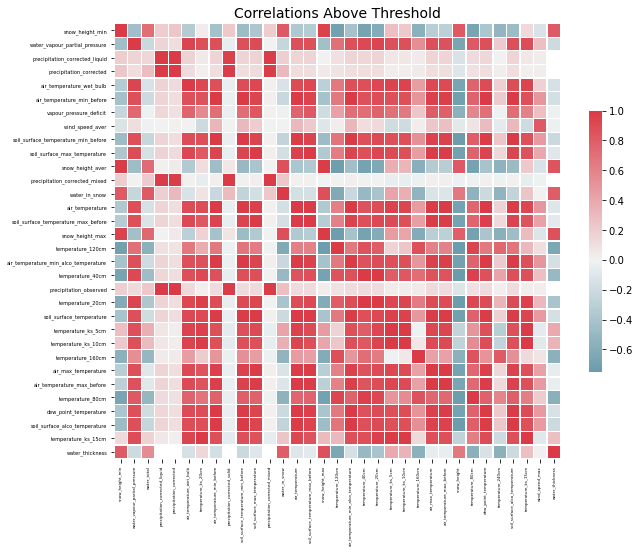

In [16]:
#строим корреляционную матрицу между нашими признаками

fs.plot_collinear()

In [17]:
collinear_features = fs.ops['collinear']

In [18]:
#Выводим коллинеарные между собой признаки

collinear_features

['air_temperature',
 'air_temperature_wet_bulb',
 'water_vapour_partial_pressure',
 'dew_point_temperature',
 'soil_surface_alco_temperature',
 'soil_surface_temperature_min_before',
 'air_temperature_min_alco_temperature',
 'air_temperature_min_before',
 'wind_speed_max',
 'soil_surface_temperature_max_before',
 'soil_surface_max_temperature',
 'air_temperature_max_before',
 'air_max_temperature',
 'snow_height_max',
 'snow_height_min',
 'water_thickness',
 'water_in_snow',
 'water_total',
 'snow_height',
 'temperature_20cm',
 'temperature_40cm',
 'temperature_80cm',
 'temperature_120cm',
 'temperature_160cm',
 'temperature_240cm',
 'temperature_ks_5cm',
 'temperature_ks_10cm',
 'temperature_ks_15cm',
 'temperature_ks_20cm',
 'precipitation_corrected',
 'precipitation_corrected_liquid',
 'precipitation_corrected_mixed',
 'precipitation_corrected_solid']

In [19]:
len(collinear_features)

33

In [20]:
collinear = fs.record_collinear

In [21]:
collinear

,drop_feature,corr_feature,corr_value
0,air_temperature,soil_surface_temperature,0.993802
1,air_temperature_wet_bulb,soil_surface_temperature,0.916718
2,air_temperature_wet_bulb,air_temperature,0.903752
3,water_vapour_partial_pressure,soil_surface_temperature,0.888800
4,water_vapour_partial_pressure,air_temperature,0.871916
5,water_vapour_partial_pressure,air_temperature_wet_bulb,0.936680
6,dew_point_temperature,soil_surface_temperature,0.984950
7,dew_point_temperature,air_temperature,0.990964
8,dew_point_temperature,air_temperature_wet_bulb,0.901843
9,dew_point_temperature,water_vapour_partial_pressure,0.889694


In [25]:
# с помощью функции длеаем новые признаки или удаляем те, значение в корреляционной матрице у которых высокое

def feature_selection(df):
    
    df['delta_temp20_80']=df['temperature_20cm']-df['temperature_80cm']
    df['delta_temp40_120']=df['temperature_40cm']-df['temperature_120cm']
    df['delta_temp160_320']=df['temperature_160cm']-df['temperature_320cm']
    
    df = df.drop(['air_temperature_wet_bulb',
                  'snow_height_max',
                  'snow_height_min',
                  'temperature_20cm',
                  'temperature_40cm',    
                  'temperature_80cm',
                  'temperature_120cm',
                  'temperature_160cm',
                  'temperature_320cm',
                  'temperature_ks_5cm',
                  'temperature_ks_10cm',
                  'temperature_ks_15cm',
                  'temperature_ks_20cm',
                  'precipitation_corrected_liquid',
                  'precipitation_corrected_mixed',
                  'precipitation_corrected_solid',
                  'soil_surface_temperature_min_before',
                  'soil_surface_temperature_max_before',
                  'air_temperature_min_alco_temperature',
                  'air_temperature_min_before',
                  'cloud_form_high_level', 
                  'cloud_form_middle_level',
                  'cloud_form_vertical_develop', 
                  'cloud_form_strat_stratocum',
                  'cloud_form_strat_rain', 
                  'cloud_below_station',
                  'water_thickness', 
                  'water_in_snow',
                  'wind_speed_max',
                  'soil_surface_condition',
                  'snow_saturated_thickness',], axis=1)
    
    return df


In [26]:
new_df = feature_selection(interpolated_meteo)

In [27]:
#проверяем получившийся dataframe

new_df.head()

,station_id,date,horizontal_visibility,cloud_amount_total,cloud_base_altitude,wind_direction,wind_speed_aver,soil_surface_temperature,air_temperature,water_vapour_partial_pressure,relative_humidity,vapour_pressure_deficit,dew_point_temperature,pressure,pressure_sea_level,barometric_tendency,soil_surface_alco_temperature,soil_surface_max_temperature,air_temperature_max_before,air_max_temperature,weather_before,weather,air_temperature_wet_bulb_qual_1,barometric_tendency_characteristic,precipitation,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_density_aver,ice_crust_aver,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,temperature_240cm,precipitation_observed,precipitation_corrected,sunshine_hours,delta_temp20_80,delta_temp40_120,delta_temp160_320
0,3019,1985-01-01,1.692293,8.599151,1280.000000,105.007568,1.124210,-32.986135,-30.124586,0.415020,78.963205,0.120962,-32.861411,982.381929,1033.549713,1.349936,-39.152369,-25.374530,-22.101804,-23.001084,5.576960,2.000000,0.0,2.0,0.436285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.991904,10.0,-3.555556,22.323869,26.005038,49.892629,-35.446674,-28.261691,-13.328619
1,3021,1985-01-01,1.840137,8.209060,1274.863984,103.008547,1.080106,-32.869759,-30.026464,0.423947,77.834769,0.117128,-32.740446,984.805554,1033.525155,1.338653,-39.164859,-25.204422,-22.149908,-23.065267,5.305459,2.000000,0.0,2.0,0.290685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.005516,10.0,-3.555556,18.347657,22.579135,46.013656,-36.412567,-25.616162,-12.411724
2,3024,1985-01-01,1.522114,7.470050,1280.000000,14.663596,0.277282,-32.933649,-28.811941,0.479949,79.031396,0.118337,-31.105532,1000.888361,1033.152817,1.488127,-40.772342,-25.405791,-24.191229,-24.708260,7.000000,71.000000,0.0,2.0,1.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.406889,10.0,-3.555556,23.424148,28.047122,21.962523,-35.590389,-25.949495,-21.619659
3,3027,1985-01-01,1.215960,7.548409,1280.000000,37.472836,0.249645,-32.396618,-28.664371,0.474838,78.229912,0.120152,-31.227767,996.518517,1032.435091,1.536286,-40.574750,-26.336547,-24.012779,-24.710245,7.000000,69.232819,0.0,2.0,0.943451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.324201,10.0,-3.555556,19.917634,25.352980,33.137939,-35.862179,-29.350188,-24.728817
4,3028,1985-01-01,1.211661,7.544147,1280.000000,46.843845,0.344743,-32.793145,-29.017344,0.460288,78.281317,0.117356,-31.552094,999.202514,1032.443341,1.549137,-40.314002,-26.449682,-24.162946,-24.974845,7.000000,51.368721,0.0,2.0,0.900009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.957503,10.0,-3.555556,19.785842,25.384279,33.015128,-35.862179,-31.171717,-23.881197


In [28]:
new_df.shape

(336447, 43)

In [ ]:
new_df.to_csv('new_df.csv', index=False)